Use the Crystal Ball function to stochastically select decays. This attempts to simulate the effect of removing the background from the signal based on the fractions predicted by the Crystal Ball function. 

1. Load classified total dataset 
2. Fit crystal ball (to J/Psi region first)
3. Plot crystal ball (separating out background + signal) 
4. Generate random selections 
5. Save random selections

In [1]:
import scipy as sp
from scipy.optimize import curve_fit
from scipy.special import erf

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functools import partial

In [2]:
from selection_criteria.functions import cut_data
import crystal_ball as cry

## import J/Psi data

In [3]:
data_path = '../data/'
total_path = f'{data_path}total_dataset.pkl'
total_dataset_jpsi = pd.read_pickle(total_path)

jpsi_path = f'{data_path}jpsi.pkl' 
jpsi = pd.read_pickle(jpsi_path)

signal_path = f'{data_path}signal.pkl'
signal = pd.read_pickle(signal_path)

len(total_dataset_jpsi)

498245

In [52]:
cut_q2 = [[0.98,1.10],[8.,11.],[12.5,15.]]
def selection_7(data, cut_q2=cut_q2):
    return cut_data(data, cut_q2)

total_dataset_jpsi = selection_7(total_dataset_jpsi, cut_q2=[cut_q2[1]]) # only keep J/Psi dominated regions
len(total_dataset_jpsi)

123717

## import data

In [5]:
data_folder = './final_data_processed/'
total_dataset = pd.read_pickle(f'{data_folder}/total_dataset_classified.pkl')
acceptance = pd.read_pickle(f'{data_folder}/acceptance_classified.pkl')

## extract q2 bins

In [6]:
from data_loader import extract_bin_number, q2_ranges

In [7]:
q2_bins = q2_ranges

## fit crystal ball

Code below by Yuchen and Zhihao

In [8]:
def pretty_print_coef(A, mu, sigma1, sigma2, alpha, n, f_core, B, tau):
    print(f'mu={mu:.4f}, sigma1={sigma1:.4f}, sigma2={sigma2:.4f}, alpha={alpha:.4f}, n={n:.4f}, f_core={f_core:.4f}')
    print(f'A1={A:.4f}, B={B:.4f}, tau={tau:.4f}')

In [69]:
def crystal_ball(m, A, mu, sigma, alpha, n):
    a = (n/abs(alpha))**n * np.exp(-0.5*alpha**2)
    b = n/abs(alpha) - abs(alpha)

    x = (m-mu)/sigma
    c = -abs(alpha)
    
    return np.piecewise(x, [x > c, x <= c], 
                [lambda x: A * np.exp(-0.5*(x)**2),
                 lambda x: A * (a / (b-x)**n)])

def crystal_ball_norm(m, mu, sigma, alpha, n):
    abs_alpha = abs(alpha)
    
    a = (n/abs_alpha)**n * np.exp(-0.5*alpha**2)
    b = n/abs_alpha - abs_alpha
    
    d = np.sqrt(np.pi/2) * (1 + erf(abs_alpha / np.sqrt(2)))
    e = n * np.exp(-abs_alpha**2 / 2) / abs_alpha / (n-1)
    A = 1 / sigma / (d + e)

    x = (m-mu)/sigma
    c = -abs(alpha)
    
    return np.piecewise(x, [x > c, x <= c], 
                [lambda x: A * np.exp(-0.5*(x)**2),
                 lambda x: A * (a / (b-x)**n)])


def exp_bg(m, B, tau):
    return B * np.exp(-tau*(m-5170))


def signal_model(m, A, mu, sigma1, sigma2, alpha, n, f_core):
    cb1 = crystal_ball_norm(m, mu, sigma1, alpha, n)
    cb2 = crystal_ball_norm(m, mu, sigma2, alpha, n)
    return A * (f_core * cb1 + (1 - f_core) * cb2)


def signal_bg_model(m, A, mu, sigma1, sigma2, alpha, n, f_core, B, tau):
    return signal_model(m, A, mu, sigma1, sigma2, alpha, n, f_core) + exp_bg(m, B, tau)

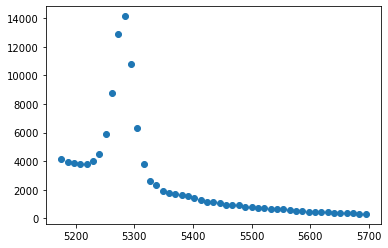

In [171]:
hist, bin_edges = np.histogram(total_dataset_jpsi['B0_MM'], bins=np.linspace(5170,5700,50))
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.scatter(bin_centers, hist)

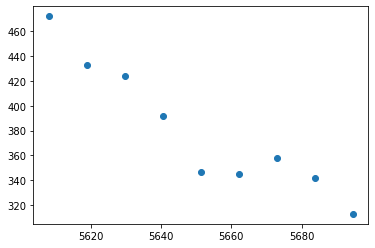

In [172]:
m_cut = bin_centers > 5600 #np.logical_or(bin_centers > 5400, bin_centers < 5200)
plt.scatter(bin_centers[m_cut], hist[m_cut])

[3.30034713e+03 4.50402506e-03]


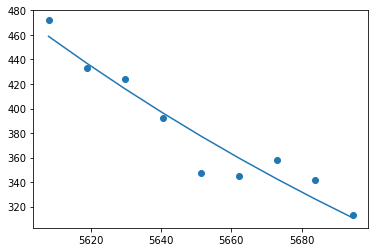

In [173]:
p0 = [hist[m_cut][0], 4e-3]
popt_bg, pcov_bg = curve_fit(exp_bg, bin_centers[m_cut], hist[m_cut], p0=p0)
print(popt_bg)
plt.scatter(bin_centers[m_cut], hist[m_cut])
plt.plot(bin_centers[m_cut], exp_bg(bin_centers[m_cut], *popt_bg))

/var/folders/n_/30ql5zx10yqgx8_vzrslnc180000gn/T/ipykernel_36946/2050547209.py:15: RuntimeWarning: overflow encountered in double_scalars
  a = (n/abs_alpha)**n * np.exp(-0.5*alpha**2)
/var/folders/n_/30ql5zx10yqgx8_vzrslnc180000gn/T/ipykernel_36946/2050547209.py:15: RuntimeWarning: invalid value encountered in double_scalars
  a = (n/abs_alpha)**n * np.exp(-0.5*alpha**2)
/var/folders/n_/30ql5zx10yqgx8_vzrslnc180000gn/T/ipykernel_36946/2050547209.py:27: RuntimeWarning: overflow encountered in power
  lambda x: A * (a / (b-x)**n)])
/var/folders/n_/30ql5zx10yqgx8_vzrslnc180000gn/T/ipykernel_36946/2050547209.py:27: RuntimeWarning: invalid value encountered in true_divide
  lambda x: A * (a / (b-x)**n)])


mu=5281.0191, sigma1=14.7866, sigma2=27.4068, alpha=1.4216, n=5.0972, f_core=0.6495
A1=552316.8996, B=4203.9592, tau=0.0050


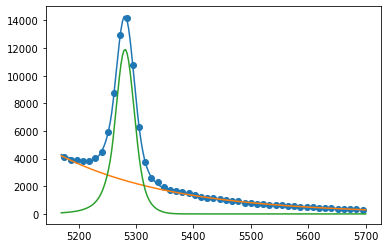

In [176]:
# A, mu, sigma1, sigma2, alpha, n, f_core
p0 = [3.5e5, 5280, 15, 26, 1.5, 5.2, 0.7, *popt_bg]
bounds = [(-np.inf, np.inf)]*len(p0)
# bounds[5] = (3, 9)
bounds[6] = (0.5, 1)
xscale = [1e5, 5280, 15, 26, 1.5, 5.2, 0.7]

# signal_bg_model_partial = partial(signal_bg_model, B=popt_bg[0], tau=popt_bg[1])
popt, pcov = curve_fit(signal_bg_model, bin_centers, hist, p0=p0, #sigma=np.sqrt(hist),
                       bounds=tuple(zip(*bounds)), method='trf',
                       jac='3-point', x_scale='jac', loss='soft_l1')

plt.scatter(bin_centers, hist)
x_fit = np.linspace(np.min(bin_edges), np.max(bin_edges), 200)
plt.plot(x_fit, signal_bg_model(x_fit, *popt,))

plt.plot(x_fit, exp_bg(x_fit, *popt[-2:]))
plt.plot(x_fit, signal_model(x_fit, *popt[:-2]))

# plt.yscale('log')

pretty_print_coef(*popt, )

[0.55773392 0.91746586]


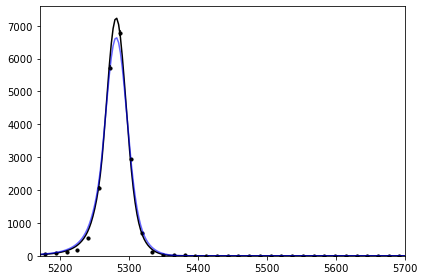

[0.33008123 0.92772042]


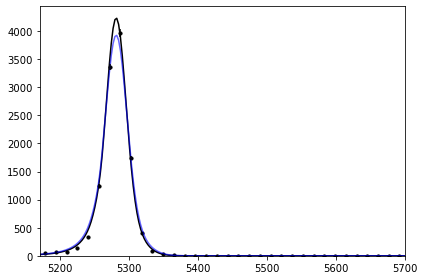

[0.32274347 0.92997531]


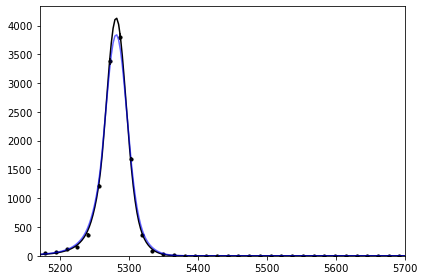

[0.49541714 0.9436387 ]


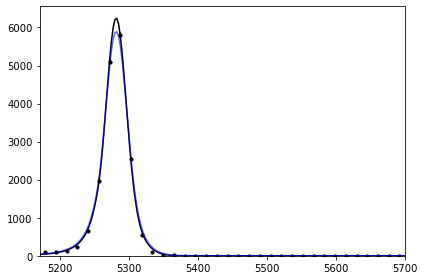

[0.67221255 0.92428222]


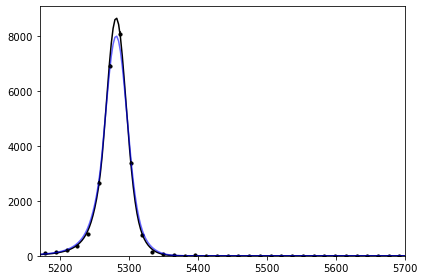

[0.86246028 0.99310254]


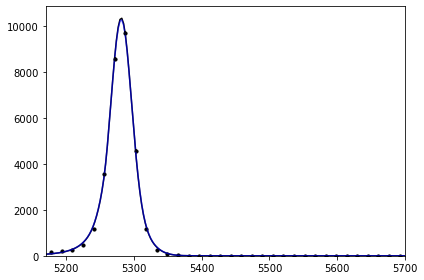

[0.4656583  1.00283287]


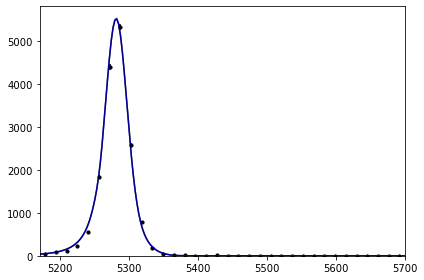

[0.76923945 0.94374334]


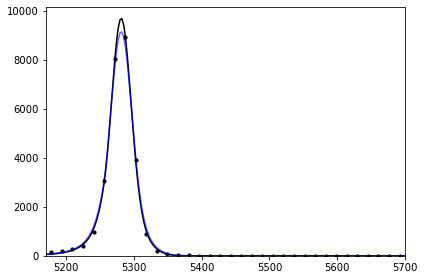

[1.17653088 0.93392607]


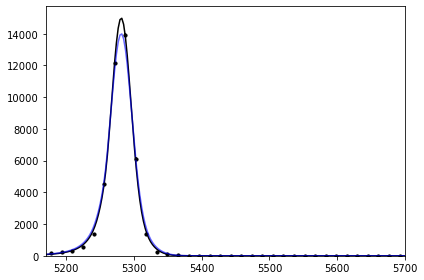

[1.13646308 0.99440682]


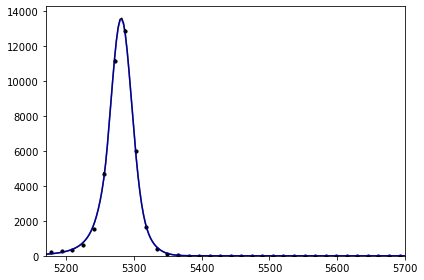

In [186]:
## fit signal

sigma_scales = []
for i in range(10):
    hist, bin_edges = np.histogram(extract_bin_number(signal, i)['B0_MM'], bins=np.linspace(5170,5700,35))
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

    def normalise_fit_curve(popt):
        popt = np.copy(popt)
        sigma1 = popt[2]
        sigma2 = popt[3]
        def f(m, A, sigma_scale):
            popt[2] = sigma_scale * sigma1
            popt[3] = sigma_scale * sigma2
            
            return A * signal_model(m, *popt[:-2])
        return f
    
#     sigma = np.sqrt(hist)
#     below_zero = sigma == 0
#     sigma[below_zero] = np.min(sigma[below_zero])
    p0 = [0.5, 1]
    popt_norm, pcov_norm = curve_fit(normalise_fit_curve(popt), bin_centers, hist, p0=p0)# sigma=sigma,
#                                      method='trf', loss='soft_l1')
    x_fit = np.linspace(np.min(bin_edges), np.max(bin_edges), 200)
    plt.plot(x_fit, normalise_fit_curve(popt)(x_fit, *popt_norm), c='black')
    
    plt.plot(x_fit, popt_norm[0] * signal_model(x_fit, *popt[:-2]), c='blue', alpha=0.6)
    print(popt_norm)
    sigma_scales.append(popt_norm[1])
    
    plt.scatter(bin_centers, hist, c='black', s=10)
    plt.errorbar(bin_centers, hist, yerr=np.sqrt(hist), fmt='none', c='black')
    
    plt.ylim([0, None])
    plt.xlim([5170, 5700])
    
    plt.tight_layout()
    plt.show()

In [188]:
sigma_scales

[0.9174658631558328,
 0.927720424520793,
 0.9299753148573889,
 0.9436387004875569,
 0.9242822229306857,
 0.9931025366815743,
 1.0028328661774388,
 0.9437433378715816,
 0.9339260711742255,
 0.9944068238329379]

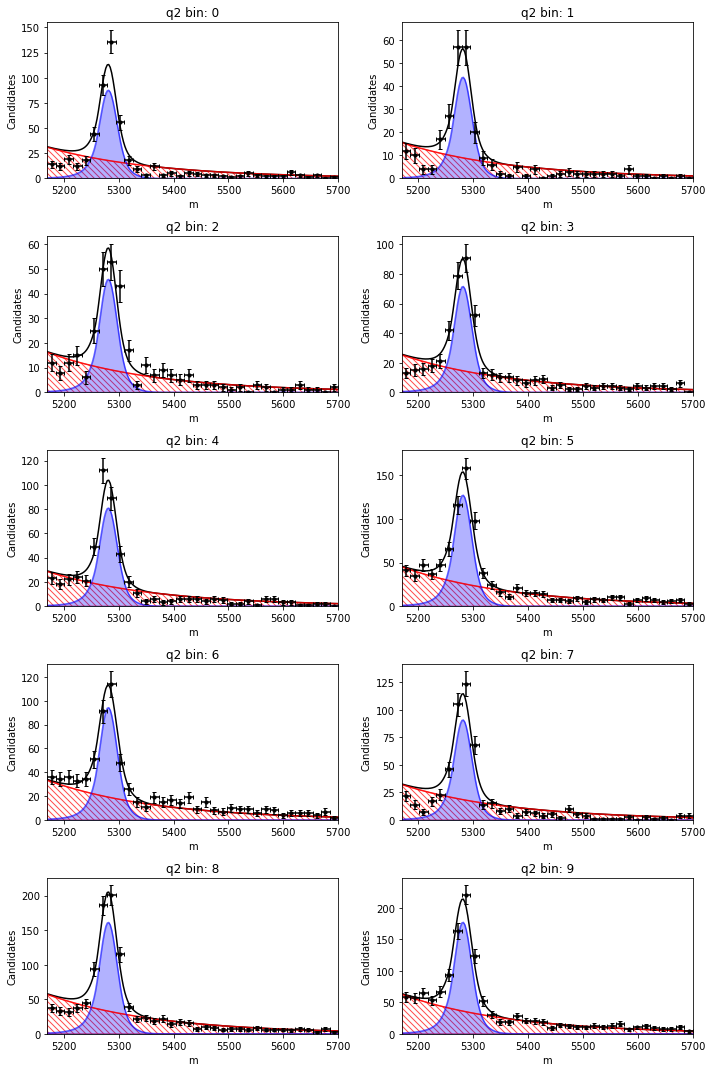

In [197]:
plt.figure(figsize=(10, 15))
for i in range(10):
    bins = np.linspace(5170,5700,35)
    bin_diffs = bins[1] - bins[0]
    hist, bin_edges = np.histogram(extract_bin_number(total_dataset, i)['B0_MM'], bins=bins)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

    def normalise_fit_curve(popt):
        popt = np.copy(popt)
        sigma1 = popt[2]
        sigma2 = popt[3]
        def f(m, A):
            popt[2] = sigma_scales[i] * sigma1
            popt[3] = sigma_scales[i] * sigma2
            return A * signal_bg_model(m, *popt)
        return f
    
#     sigma = np.sqrt(hist)
#     below_zero = sigma == 0
#     sigma[below_zero] = np.min(sigma[below_zero])
    popt_norm, pcov_norm = curve_fit(normalise_fit_curve(popt), bin_centers, hist,)# sigma=sigma,
#                                      method='trf', loss='soft_l1')

    plt.subplot(5, 2, i+1)
    plt.title(f'q2 bin: {i}')
    
    x_fit = np.linspace(np.min(bin_edges), np.max(bin_edges), 200)
    plt.plot(x_fit, normalise_fit_curve(popt)(x_fit, *popt_norm), c='black')
    
    plt.plot(x_fit, popt_norm[0] * exp_bg(x_fit, *popt[-2:]), c='red', alpha=0.8)
    plt.fill_between(x_fit, popt_norm[0] * exp_bg(x_fit, *popt[-2:]), 
                     color='red', facecolor='none', alpha=0.7, hatch=r'\\\\')
    
    plt.plot(x_fit, popt_norm[0] * signal_model(x_fit, *popt[:-2]), c='blue', alpha=0.6)
    plt.fill_between(x_fit, popt_norm[0] * signal_model(x_fit, *popt[:-2]), color='blue', alpha=0.3)
    
    plt.scatter(bin_centers, hist, c='black', s=10)
    plt.errorbar(bin_centers, hist, xerr=bin_diffs/2, yerr=np.sqrt(hist), fmt='none', c='black',
                capsize=2)
    
    plt.ylim([0, None])
    plt.xlim([5170, 5700])
    
    plt.xlabel('m')
    plt.ylabel('Candidates')
    
plt.tight_layout()
plt.show()

## fit overall dataset

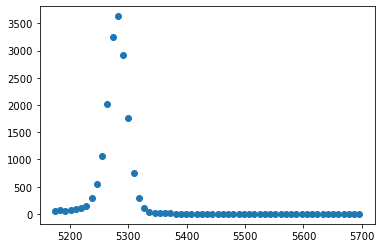

In [14]:
i = 3
data = extract_bin_number(signal, i)

hist, bin_edges = np.histogram(data['B0_MM'], bins=np.linspace(5170,5700,60))
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.scatter(bin_centers, hist)

In [15]:
def signal_bg_assumption(mu, sigma1, sigma2, alpha, n, f_core):
    def f(m, A, s1, s2, B, tau):
        return signal_bg_model(m, A, mu, s1*sigma1, s2*sigma2, alpha, n, f_core, B, tau)
    return f

sigma1=0.9493, sigma2=0.7347, tau=0.0093
A=152389.4660, B=39.0885


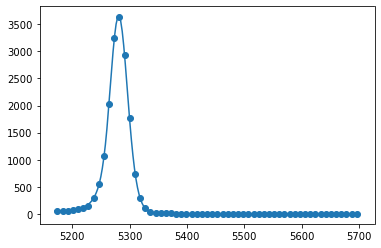

In [16]:
mu, sigma1, sigma2, alpha, n, f_core = popt[1:7]
signal_bg_frozen = signal_bg_assumption(mu, sigma1, sigma2, alpha, n, f_core)

p0 = [np.max(hist), 1, 1, 30, popt[-1]]
bounds = [(-np.inf, np.inf)]*len(p0)
# bounds[1] = (12, 19)
# bounds[2] = (27, 35)
# bounds[3] = (0, np.inf)
popt_frozen, pcov_frozen = curve_fit(signal_bg_frozen, bin_centers, hist, p0=p0, method='trf', x_scale='jac',
                                     loss='linear', max_nfev=len(hist) * 200, bounds=tuple(zip(*bounds)))

plt.scatter(bin_centers, hist)
x_fit = np.linspace(np.min(bin_edges), np.max(bin_edges), 200)
plt.plot(x_fit, signal_bg_frozen(x_fit, *popt_frozen))

def pretty_print_frozen(A, sigma1, sigma2, B, tau):
    print(f'sigma1={sigma1:.4f}, sigma2={sigma2:.4f}, tau={tau:.4f}')
    print(f'A={A:.4f}, B={B:.4f}')

pretty_print_frozen(*popt_frozen)

## previous fit

In [237]:
def fit_crystal_ball(data,sigma,alpha,n):
    # get data
    bin_height, bin_edges, patches = plt.hist(data["B0_MM"], bins = np.linspace(5170,5700,41), alpha = 0.5, rwidth=0)
    
    x = np.zeros(len(bin_height))
    for i in range (0,len(bin_edges)-1):
        x[i] = (bin_edges[i]+bin_edges[i+1])/2
    yerr = np.sqrt(bin_height)

    plt.errorbar(x,bin_height,yerr=yerr,fmt='.',c='black')

    
    # get p0
    A = np.max(bin_height)
    mean = x[bin_height.argmax()]
    #sigma = 15
    #alpha = 1.5
    #n=75
    coe = bin_height[0]
    tau = np.log(bin_height[0]/(np.mean(bin_height[-15:-1])))*1/590
    
    p0 = [A,mean,sigma,alpha,n,coe,tau]
    #p0 = [A,mean,sigma,coe,tau]
    
    # fitting 
    popt,pcov = curve_fit(cry.crystal_ball, x, bin_height,p0 = p0)
    
    x_plot = np.linspace(5170,5700,500)
    y = cry.crystal_ball(x_plot,*popt)

    plt.plot(x_plot,y)
    plt.xlim([5170,5700])
    plt.xlabel("M_B0/MeV")
    plt.grid()
    
    
    # print('A = %.3f +- %.3f'%(popt[0],pcov[0][0]**0.5))
    # print('mu = %.3f +- %.3f'%(popt[1],pcov[1][1]**0.5))
    # print('sigma = %.3f +- %.3f'%(popt[2],pcov[2][2]**0.5))
    # print('alpha = %.3f +- %.3f'%(popt[3],pcov[3][3]**0.5))
    # print('n = %.3f +- %.3f'%(popt[4],pcov[4][4]**0.5))
    # print('coe = %.3f +- %.3f'%(popt[5],pcov[5][5]**0.5))
    # print('tau = %.4f +- %.4f'%(popt[6],pcov[6][6]**0.5))
    # print('++++++++++++++++')
    return popt,pcov

/Users/zhenghe/Documents/Programming/TBPS/classification/crystal_ball.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (n/abs(alpha))**n*np.exp(-0.5*alpha**2)
/Users/zhenghe/Documents/Programming/TBPS/classification/crystal_ball.py:51: RuntimeWarning: invalid value encountered in power
  return np.piecewise(x, [x > c, x <= c], [lambda x: A*(np.exp(-0.5*(x)**2)) + exponential_background(x*sigma+mu,coe,tau), lambda x: A*((a/(b-(x))**n)) + exponential_background(x*sigma+mu,coe,tau)])
/Users/zhenghe/Documents/Programming/TBPS/classification/crystal_ball.py:45: RuntimeWarning: overflow encountered in double_scalars
  a = (n/abs(alpha))**n*np.exp(-0.5*alpha**2)
/Users/zhenghe/Documents/Programming/TBPS/classification/crystal_ball.py:51: RuntimeWarning: overflow encountered in power
  return np.piecewise(x, [x > c, x <= c], [lambda x: A*(np.exp(-0.5*(x)**2)) + exponential_background(x*sigma+mu,coe,tau), lambda x: A*((a/(b-(x))**n)) + exponential_background(x*sigma+mu,c

A=58252.76725936664, mu=5281.248468581485, sigma=17.440273675968914, alpha=1.0791229892218834, n=144.12268937648386, coe=19852.488217642098


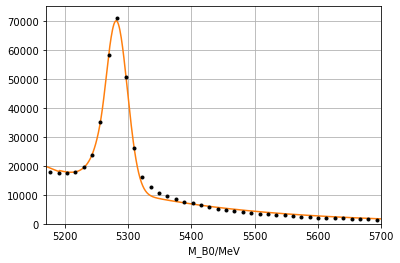

In [33]:
opt,cov = fit_crystal_ball(total_dataset_jpsi, 12, 1.5, 50)
pretty_print_coef(*opt)

/Users/zhenghe/Documents/Programming/TBPS/classification/crystal_ball.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (n/abs(alpha))**n*np.exp(-0.5*alpha**2)
/Users/zhenghe/Documents/Programming/TBPS/classification/crystal_ball.py:51: RuntimeWarning: invalid value encountered in power
  return np.piecewise(x, [x > c, x <= c], [lambda x: A*(np.exp(-0.5*(x)**2)) + exponential_background(x*sigma+mu,coe,tau), lambda x: A*((a/(b-(x))**n)) + exponential_background(x*sigma+mu,coe,tau)])
/Users/zhenghe/Documents/Programming/TBPS/classification/crystal_ball.py:45: RuntimeWarning: overflow encountered in double_scalars
  a = (n/abs(alpha))**n*np.exp(-0.5*alpha**2)
/Users/zhenghe/Documents/Programming/TBPS/classification/crystal_ball.py:51: RuntimeWarning: overflow encountered in power
  return np.piecewise(x, [x > c, x <= c], [lambda x: A*(np.exp(-0.5*(x)**2)) + exponential_background(x*sigma+mu,coe,tau), lambda x: A*((a/(b-(x))**n)) + exponential_background(x*sigma+mu,c

A=156998.44740086145, mu=5281.330966003742, sigma=17.703686855215373, alpha=1.0883976869231367, n=144.60205476135596, coe=14330.108085631251


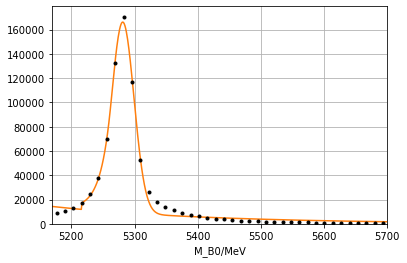

In [34]:
opt,cov = fit_crystal_ball(jpsi, 12, 1.5, 50)
pretty_print_coef(*opt)

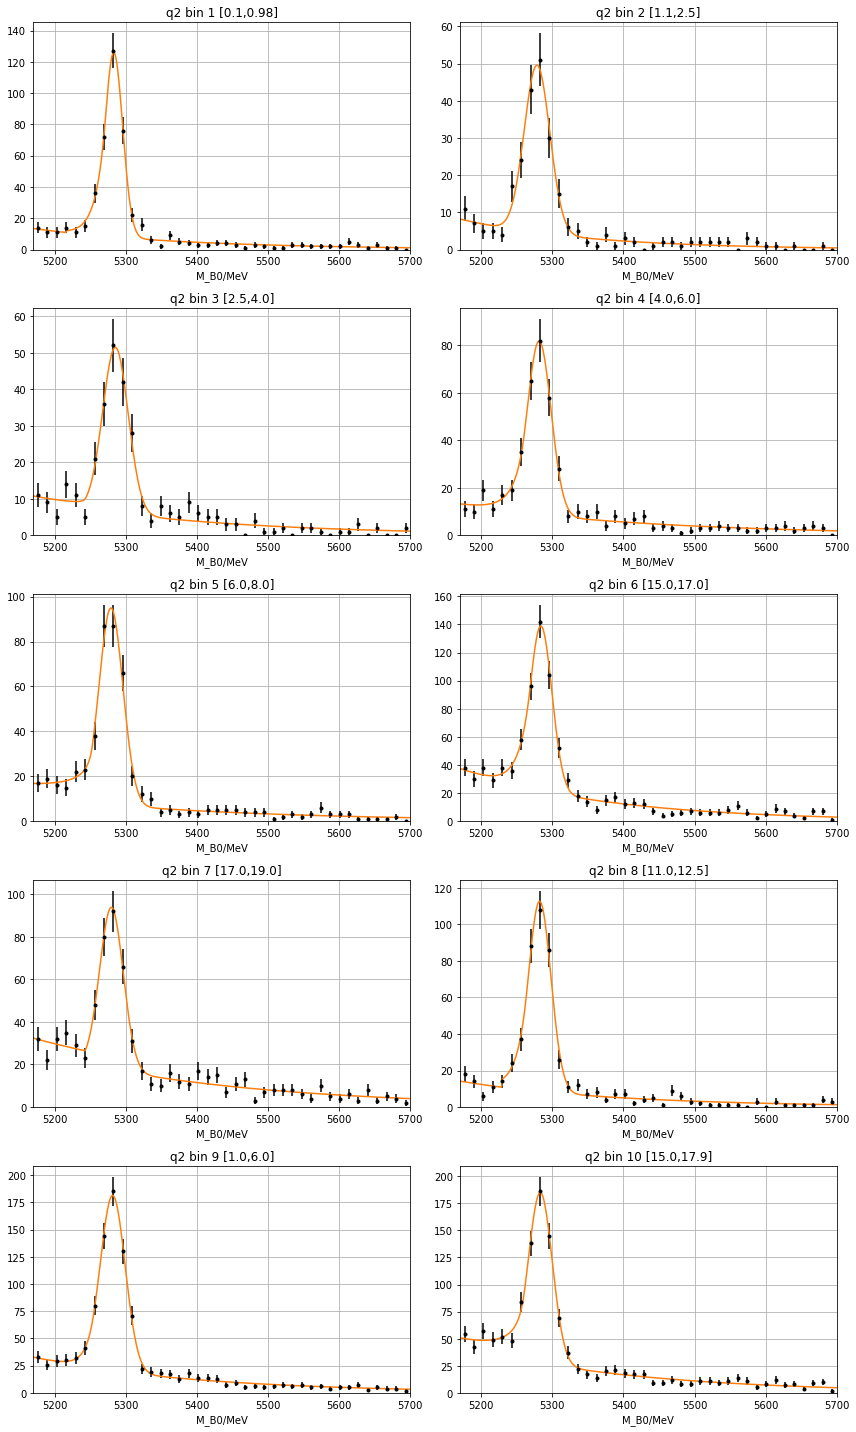

In [11]:
# this cell may print warings un-usedtthe first three lines to display
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    
    Var = [[] for i in range (0,7)]
    Err = [[] for i in range (0,7)]
    
    n = [75,2,80,75,75,50,80,50,75,75]
    alpha = [1.5,15,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5]
    sigma = [15,18,10,15,15,15,10,15,15,15]
    #opt,cov = fit_crystal_ball(binned_data[-4],alpha[-4],n[-4])
    #print(opt[-3])
    #print(opt[-4])
    
    
    plt.figure(figsize=[6*2,4*5],tight_layout=True)
    for i in range(0,10):
        #print(f'q2 bin {i+1} [{q2_bins[i][0]},{q2_bins[i][1]}]')
        plt.subplot(5,2,i+1)
        plt.title(f'q2 bin {i} [{q2_bins[i][0]},{q2_bins[i][1]}]')
        opt,cov = fit_crystal_ball(extract_bin_number(total_dataset, i),sigma[i],alpha[i],n[i])
        for j in range(0,7):
            Var[j].append(opt[j])
            Err[j].append(cov[j][j]**0.5) 
    plt.show()
    
    

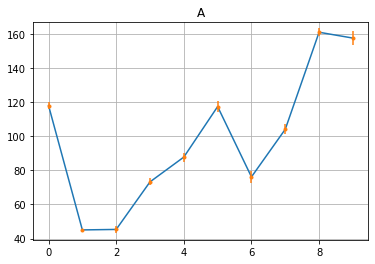

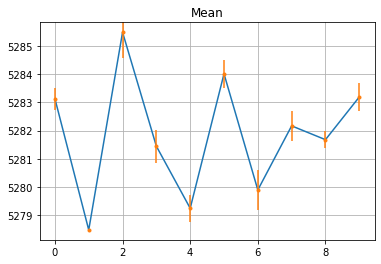

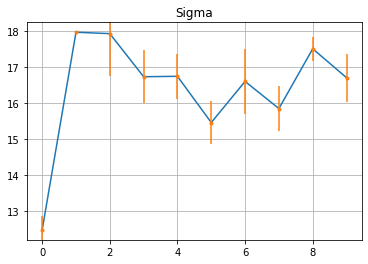

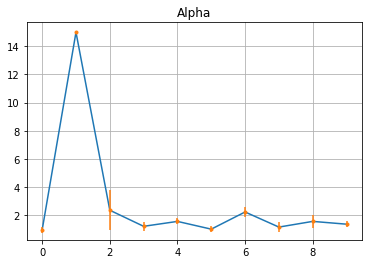

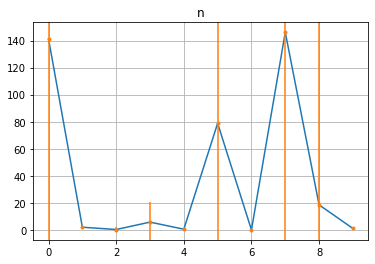

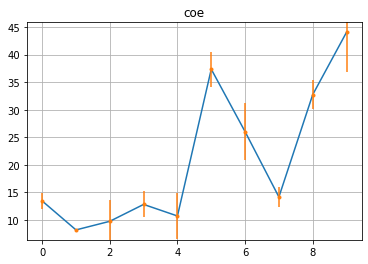

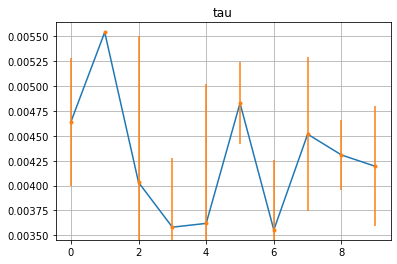

In [12]:
num = np.arange(10)
title = ["A","Mean",'Sigma','Alpha','n','coe','tau']
for i in range(len(Var)):
    plt.figure()
    plt.title(title[i])
    plt.plot(num,Var[i])
    plt.errorbar(num,Var[i],yerr=Err[i],fmt='.')
    plt.grid()
    plt.show()